People always ask: "can you randomize several times and use the proportion of selection, instead of
just one randomization"?

Let's try to figure this out.

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
[1.74114078 7.26057398]


0.44278782352569235

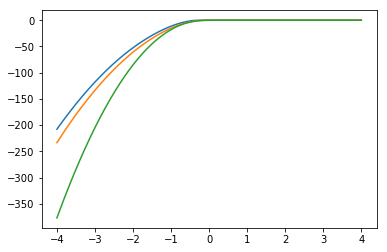

In [2]:
import numpy as np
import regreg.api as rr
import seaborn as sns
%matplotlib inline
%load_ext rpy2.ipython

import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm

from selection.distributions.discrete_family import discrete_family

ntries, sigma, q = 21, 0.5, 0.3

def algorithm(Z, ntries=ntries, q=q):
    
    proportion = 0
    for _ in range(ntries):
        proportion += (Z + sigma * np.random.standard_normal() > 0)

    proportion /= ntries
    return proportion > q

def fit_algorithm(algorithm, B=10000, ntries=ntries, q=q):
    
    Z = np.random.standard_normal(B) * 2
    Y = np.array([algorithm(z, ntries=ntries, q=q) for z in Z])
    
    %R -i Y,Z M = glm(Y ~ Z, family=binomial(link=probit))
    coefM = %R coef(M)
    
    return coefM

coefM = fit_algorithm(algorithm)
print(coefM)
def simulate(n=100, ntries=ntries, sigma=sigma, truth=0):
               
    while True:
        Z = np.random.standard_normal() + truth
        if algorithm(Z, ntries, q=q):
            return Z

simulate()

def weight(Z, ntries=ntries, sigma=0.5, q=q):
    piZ = scipy.stats.norm.sf(-Z/sigma)
    return scipy.stats.binom.sf(ntries * q, ntries, piZ)

def weight_fit(Z, coef=coefM):
    linpred = coefM[0] + coefM[1] * Z
    return scipy.stats.norm.cdf(linpred)

def weight_LD(Z, ntries=ntries, sigma=0.5, q=q):
    phiZ = scipy.stats.norm.sf(-Z/sigma)
    return np.exp(-ntries * (q * np.log(q / phiZ) + (1 - q) * np.log((1 - q) / (1 - phiZ)))) * (phiZ < q) + (phiZ >= q)

weight(0.2)
Z = np.linspace(-4, 4, 1001)
W = [weight_LD(z) for z in Z]
W0 = [weight(z) for z in Z]
W1 = [weight_fit(z) for z in Z]
plt.plot(Z, np.log(W))
plt.plot(Z, np.log(W0))
plt.plot(Z, np.log(W1))
selective_law = discrete_family(Z, W * scipy.stats.norm.pdf(Z))
selective_law0 = discrete_family(Z, W0 * scipy.stats.norm.pdf(Z))
selective_law1 = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))

def pivot(z, truth=0):
    return 1 - selective_law.cdf(truth, z)

def pivot0(z, truth=0):
    return 1 - selective_law0.cdf(truth, z)

def pivot1(z, truth=0):
    return 1 - selective_law0.cdf(truth, z)

pivot(simulate())


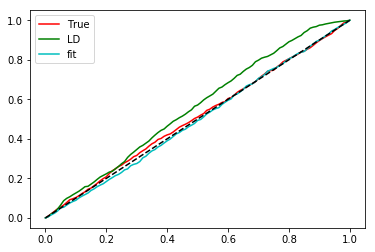

In [3]:
P0 = []

for _ in range(1000):
    P0.append((pivot(simulate()), pivot0(simulate()), pivot1(simulate())))
P0 = np.array(P0)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(P0[:,1])(U), 'r', label='True')
plt.plot(U, sm.distributions.ECDF(P0[:,0])(U), 'g', label='LD')
plt.plot(U, sm.distributions.ECDF(P0[:,2])(U), 'c', label='fit')

plt.plot([0, 1], [0, 1], 'k--')
plt.legend()

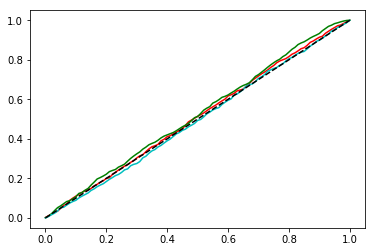

In [4]:
PA = []

for _ in range(1000):
    PA.append((pivot(simulate(truth=1), truth=1), 
               pivot0(simulate(truth=1), truth=1),
               pivot1(simulate(truth=1), truth=1)))
PA = np.array(PA)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(PA[:,1])(U), 'r', label='True')
plt.plot(U, sm.distributions.ECDF(PA[:,0])(U), 'g', label='LD')
plt.plot(U, sm.distributions.ECDF(P0[:,2])(U), 'c', label='fit')

plt.plot([0, 1], [0, 1], 'k--')

In [5]:
selective_law.equal_tailed_interval(-1)

(-39.43865206708264, -17.7458338945535)

In [6]:
Z0 = np.linspace(-2,2,501)
selective_law = discrete_family(Z, W * scipy.stats.norm.pdf(Z))

LU = []
for z in Z0:
    selective_law = discrete_family(Z, W * scipy.stats.norm.pdf(Z))
    LU.append(selective_law.equal_tailed_interval(z))
LU = np.array(LU)

LU0 = []
for z in Z0:
    selective_law = discrete_family(Z, W0 * scipy.stats.norm.pdf(Z))
    LU0.append(selective_law.equal_tailed_interval(z))
LU0 = np.array(LU0)

LU = []
for z in Z0:
    selective_law = discrete_family(Z, W * scipy.stats.norm.pdf(Z))
    LU.append(selective_law.equal_tailed_interval(z))
LU = np.array(LU)

LU1 = []
for z in Z0:
    selective_law = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))
    LU1.append(selective_law.equal_tailed_interval(z))
LU1 = np.array(LU1)

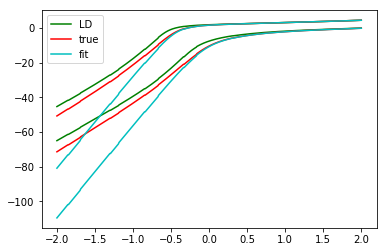

In [7]:
plt.plot(Z0, LU[:,0], 'g', label='LD')
plt.plot(Z0, LU[:,1], 'g')
plt.plot(Z0, LU0[:,0], 'r', label='true')
plt.plot(Z0, LU0[:,1], 'r')
plt.plot(Z0, LU1[:,0], 'c', label='fit')
plt.plot(Z0, LU1[:,1], 'c')
plt.legend()

In [8]:
coverage, ncover, truth = 0, 500, 0
lengths = []
for _ in range(ncover):
    z = simulate(truth=truth)
    selective_law = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))
    L, U = selective_law.equal_tailed_interval(z)
    coverage += (L < truth) * (U > truth)
    lengths.append(U-L)
    
coverage / ncover, np.mean(lengths), np.std(lengths)

(0.942, 8.426604905277545, 4.366354324284403)

In [9]:
coverage, ncover, truth = 0, 500, 0.5
lengths = []
for _ in range(ncover):
    z = simulate(truth=truth)
    selective_law = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))
    L, U = selective_law.equal_tailed_interval(z)
    coverage += (L < truth) * (U > truth)
    lengths.append(U-L)
    
coverage / ncover, np.mean(lengths), np.std(lengths)

(0.958, 7.281141199947764, 3.6787210641830073)

In [10]:
coverage, ncover, truth = 0, 500, -3.
lengths = []
for _ in range(ncover):
    z = simulate(truth=truth)
    selective_law = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))
    L, U = selective_law.equal_tailed_interval(z)
    coverage += (L < truth) * (U > truth)
    lengths.append(U-L)
    
coverage / ncover, np.mean(lengths), np.std(lengths)

(0.938, 14.215038666804205, 5.590651315455861)

# Increasing number of tries

In [11]:
ntries, sigma, q = 31, 1, 0.65
Z = np.linspace(-4, 4, 1001)

W = [weight_LD(z, ntries=ntries, sigma=sigma, q=q) for z in Z]
W0 = [weight(z, ntries=ntries, sigma=sigma, q=q) for z in Z]

selective_law = discrete_family(Z, W * scipy.stats.norm.pdf(Z))
selective_law0 = discrete_family(Z, W0 * scipy.stats.norm.pdf(Z))

def pivot(z, truth=0):
    return 1 - selective_law.cdf(truth, z)

def pivot(z, truth=0):
    return 1 - selective_law0.cdf(truth, z)

def algorithm(Z, ntries=ntries, q=q):
    
    proportion = 0
    for _ in range(ntries):
        proportion += (Z + sigma * np.random.standard_normal() > 0)

    proportion /= ntries
    return proportion > q

def fit_algorithm(algorithm, B=10000, ntries=ntries, q=q):
    
    Z = np.random.standard_normal(B) * 2
    Y = np.array([algorithm(z, ntries=ntries, q=q) for z in Z])
    
    %R -i Y,Z M = glm(Y ~ Z, family=binomial(link=probit))
    coefM = %R coef(M)
    
    return coefM

def weight_fit(Z, coef=coefM):
    linpred = coefM[0] + coefM[1] * Z
    return scipy.stats.norm.cdf(linpred)


coefM = fit_algorithm(algorithm)

def weight_fit(Z, coef=coefM):
    linpred = coefM[0] + coefM[1] * Z
    return scipy.stats.norm.cdf(linpred)

W1 = [weight_fit(z) for z in Z]
selective_law1 = discrete_family(Z, W1 * scipy.stats.norm.pdf(Z))

pivot(simulate())


0.1035268692629705

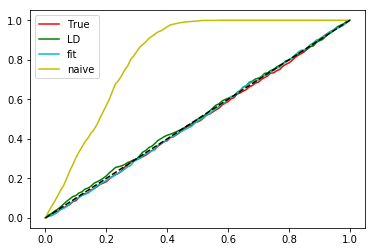

In [12]:
P0 = []
truth = 0
for _ in range(1000):
    P0.append((pivot(simulate(ntries=ntries, sigma=sigma, truth=truth)), 
               pivot0(simulate(ntries=ntries, sigma=sigma, truth=truth)),
               pivot1(simulate(ntries=ntries, sigma=sigma, truth=truth)),
              1-scipy.stats.norm.cdf(simulate(ntries=ntries, sigma=sigma, truth=truth) - truth)))
P0 = np.array(P0)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(P0[:,1])(U), 'r', label='True')
plt.plot(U, sm.distributions.ECDF(P0[:,0])(U), 'g', label='LD')
plt.plot(U, sm.distributions.ECDF(P0[:,2])(U), 'c', label='fit')
plt.plot(U, sm.distributions.ECDF(P0[:,3])(U), 'y', label='naive')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()

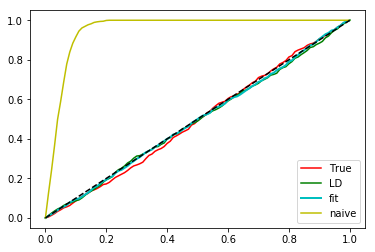

In [13]:
truth = -1
PA = []

for _ in range(1000):
    PA.append((pivot(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth), 
               pivot0(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth),
               pivot1(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth),
              1-scipy.stats.norm.cdf(simulate(ntries=ntries, sigma=sigma, truth=truth) - truth)))
PA = np.array(PA)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(PA[:,1])(U), 'r', label='True')
plt.plot(U, sm.distributions.ECDF(PA[:,0])(U), 'g', label='LD')
plt.plot(U, sm.distributions.ECDF(PA[:,2])(U), 'c', label='fit', linewidth=2)
plt.plot(U, sm.distributions.ECDF(PA[:,3])(U), 'y', label='naive')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()


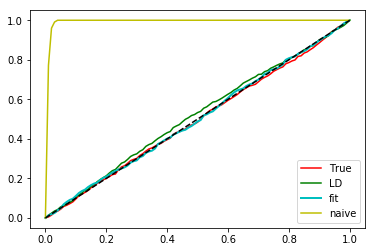

In [14]:
truth = -2
PA = []

for _ in range(1000):
    PA.append((pivot(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth), 
               pivot0(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth),
               pivot1(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth),
              1-scipy.stats.norm.cdf(simulate(ntries=ntries, sigma=sigma, truth=truth) - truth)))
PA = np.array(PA)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(PA[:,1])(U), 'r', label='True')
plt.plot(U, sm.distributions.ECDF(PA[:,0])(U), 'g', label='LD')
plt.plot(U, sm.distributions.ECDF(PA[:,2])(U), 'c', label='fit', linewidth=2)
plt.plot(U, sm.distributions.ECDF(PA[:,3])(U), 'y', label='naive')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()



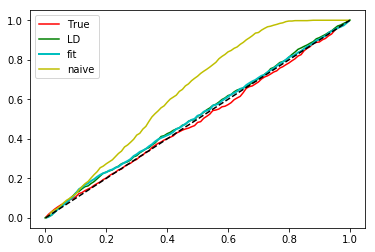

In [15]:
truth = 1
PA = []

for _ in range(1000):
    PA.append((pivot(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth), 
               pivot0(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth),
               pivot1(simulate(ntries=ntries, sigma=sigma, truth=truth), truth=truth),
              1-scipy.stats.norm.cdf(simulate(ntries=ntries, sigma=sigma, truth=truth) - truth)))
PA = np.array(PA)
U = np.linspace(0, 1, 101)
plt.plot(U, sm.distributions.ECDF(PA[:,1])(U), 'r', label='True')
plt.plot(U, sm.distributions.ECDF(PA[:,0])(U), 'g', label='LD')
plt.plot(U, sm.distributions.ECDF(PA[:,2])(U), 'c', label='fit', linewidth=2)
plt.plot(U, sm.distributions.ECDF(PA[:,3])(U), 'y', label='naive')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()



## 